#Task
- Train on letters then fine tune on digits
- will have to change the output later from 26 outputs to 10
- train on 5 epochs
- freeze the convolution layers and only fine tune the FC layers (1 epoch)
- also retrain the entire model(1 epoch)

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-16fcc63398b2>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)
images = cdata.data.view([124800,1,28,28]).float()
cdata.class_to_idx
letterCategories = cdata.classes[1:]
labels = copy.deepcopy(cdata.targets)-1
images /= torch.max(images)


100%|██████████| 561753746/561753746 [00:12<00:00, 45226457.81it/s]


Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


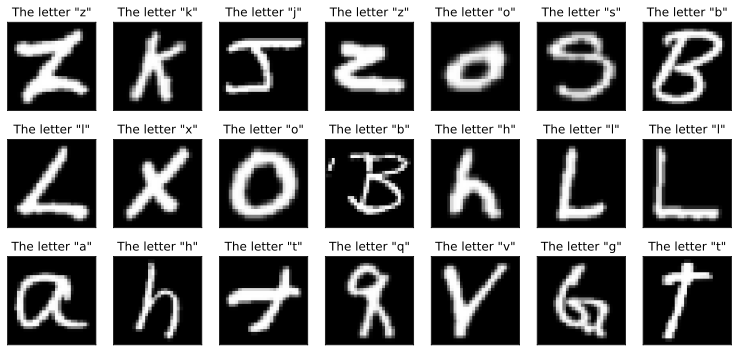

In [4]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])

  # extract the image and its target letter
  I = np.squeeze( images[whichpic,:,:] )
  letter = letterCategories[labels[whichpic]]

  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title('The letter "%s"'%letter)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [5]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
emnist_train_data = TensorDataset(train_data,train_labels)
emnist_test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
emnist_train_loader = DataLoader(emnist_train_data,batch_size=batchsize,shuffle=True,drop_last=True)
emnist_test_loader  = DataLoader(emnist_test_data,batch_size=emnist_test_data.tensors[0].shape[0])

In [6]:
### MNIST data

# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels, normalize, reshape
labelsT   = torch.tensor( data[:,0] ).long()
data      = data[:,1:]
dataNorm  = data / np.max(data)
dataNormT = torch.tensor( dataNorm.reshape(dataNorm.shape[0],1,28,28) ).float()

# split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataNormT, labelsT, test_size=.1)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize    = 32
numbers_train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
numbers_test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [36]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)
      self.fc2 = nn.Linear(50,26)

    def forward(self,x):

      if self.print: print(f'Input: {list(x.shape)}')

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [16]:
# a function that trains the model

def function2trainTheModel(net, lossfun, optimizer , train_loader, test_loader, epochs = 5):

  # number of epochs
  numepochs = epochs

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):
    print(epochi)
    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

In [13]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel(emnist_train_loader,emnist_test_loader)

0
1
2
3
4


#EMNIST Results

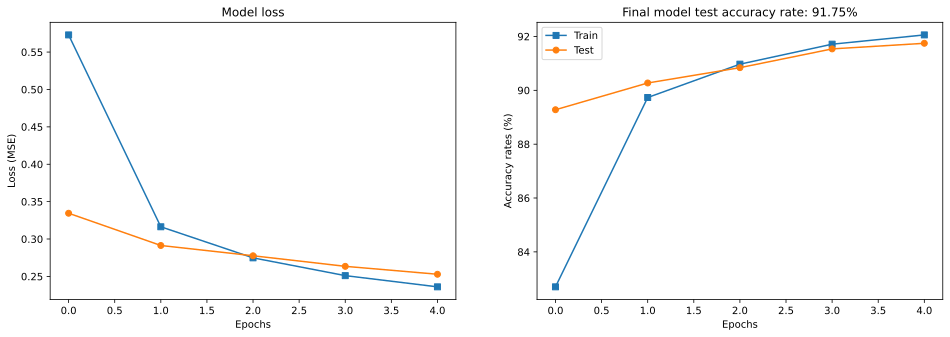

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy rates (%)')
ax[1].set_title(f'Final model test accuracy rate: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [35]:
# testing the EMNIST model with MNIST data -- bad performance which is to be expected
X,y = next(iter(numbers_test_loader))
yHat = net(X)

# the test
fashionAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

print(f'NUMBERNET performance on FASHION data: {fashionAcc:.2f}%')

NUMBERNET performance on FASHION data: 1.05%


#Transfer to MNIST
- model architecture output layer has been changed from 26 outputs to 10

In [37]:
## NOTE about this cell: I've added print() statements in here to show that the copying works.
## The first print function will show a non-zeros matrix because the weights of the two models
## differ. The second print function shows the zeros matrix because the two models have identical
## weights. See Q&A for this lecture.

# create the target model
numberNet,lossfun,optimizer = makeTheNet()
numberNet.fc2 = nn.Linear(50,10)
print( numberNet.conv1.weight[0] - numberNet.conv1.weight[0] )

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet.named_parameters(),net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

print( numberNet.conv1.weight[0] - net.conv1.weight[0] )

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<SubBackward0>)


In [38]:
# Freezing the all but the FC layers
for p in numberNet.named_parameters():
  # print(p[1])
  if 'fc' not in p[0]:
    p[1].requires_grad = False
  print(p[0], p[1].requires_grad)


conv1.weight False
conv1.bias False
bnorm1.weight False
bnorm1.bias False
conv2.weight False
conv2.bias False
bnorm2.weight False
bnorm2.bias False
fc1.weight True
fc1.bias True
fc2.weight True
fc2.bias True


<generator object Module.named_parameters at 0x792664b85770>

In [39]:
# now re-train the network on the numbers data

trainLoss,testLoss,trainAcc,testAcc,numberNet = function2trainTheModel(
                                         numberNet,lossfun,optimizer ,numbers_train_loader,numbers_test_loader,1)
print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')

0
numberNet TRAIN accuracy: 72.67%
numberNet TEST accuracy: 92.35%


#Train a Naieve MNIST

In [40]:
nieveNumberNet,lossfun,optimizer = makeTheNet()

trainLoss,testLoss,trainAcc,testAcc,numberNet = function2trainTheModel(
                                         nieveNumberNet,lossfun,optimizer ,numbers_train_loader,numbers_test_loader,1)
print(f'numberNet TRAIN accuracy: {trainAcc[-1]:.2f}%')
print(f'numberNet TEST accuracy: {testAcc[-1]:.2f}%')


0
numberNet TRAIN accuracy: 89.40%
numberNet TEST accuracy: 96.15%


- fine tuning works well for EMNIST to MNIST
- accuracy rate converts well